In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import re
from collections import Counter
import math
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, vocab_to_idx, max_len=128):
        self.texts = texts
        self.labels = labels
        self.vocab_to_idx = vocab_to_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        tokens = self.tokenize_text(text)
        token_ids = [self.vocab_to_idx.get(token, self.vocab_to_idx['<UNK>']) for token in tokens]

        if len(token_ids) > self.max_len:
            token_ids = token_ids[:self.max_len]
        else:
            token_ids = token_ids + [self.vocab_to_idx['<PAD>']] * (self.max_len - len(token_ids))

        attention_mask = [1 if token_id != self.vocab_to_idx['<PAD>'] else 0 for token_id in token_ids]

        return torch.tensor(token_ids, dtype=torch.long), torch.tensor(attention_mask, dtype=torch.long), torch.tensor(label, dtype=torch.long)

    def tokenize_text(self, text):
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        return text.split()

In [3]:
def create_vocabulary(texts, min_freq=2):
    all_tokens = []
    for text in texts:
        tokens = re.sub(r'[^a-zA-Z\s]', '', text.lower()).split()
        all_tokens.extend(tokens)

    token_counts = Counter(all_tokens)
    vocab = ['<PAD>', '<UNK>'] + [token for token, count in token_counts.items() if count >= min_freq]
    vocab_to_idx = {token: idx for idx, token in enumerate(vocab)}

    return vocab_to_idx

def load_imdb_data():
    try:
        from datasets import load_dataset
        dataset = load_dataset('imdb')

        train_texts = dataset['train']['text'][:5000]
        train_labels = dataset['train']['label'][:5000]
        test_texts = dataset['test']['text'][:1000]
        test_labels = dataset['test']['label'][:1000]

        return train_texts, train_labels, test_texts, test_labels
    except:
        positive_reviews = [
            "This movie was absolutely fantastic! Great acting and storyline.",
            "I loved every minute of it. Highly recommended!",
            "Outstanding performance by all actors. A masterpiece.",
            "Brilliant direction and excellent cinematography.",
            "One of the best films I've ever seen. Amazing!",
        ] * 500

        negative_reviews = [
            "This movie was terrible. Poor acting and boring plot.",
            "I hated it. Complete waste of time.",
            "Awful movie with bad direction and poor script.",
            "Very disappointing. Expected much better.",
            "Boring and predictable. Not worth watching.",
        ] * 500

        all_texts = positive_reviews + negative_reviews
        all_labels = [1] * len(positive_reviews) + [0] * len(negative_reviews)

        train_texts, test_texts, train_labels, test_labels = train_test_split(
            all_texts, all_labels, test_size=0.2, random_state=42
        )

        return train_texts, train_labels, test_texts, test_labels


In [4]:
def scaled_dot_product_attention(q, k, v, mask=None):
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    attention_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attention_weights, v)

    return output, attention_weights


In [32]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        if mask is not None:
            mask = mask.expand(-1, self.num_heads, -1, -1)


        attn_output, attention_weights = scaled_dot_product_attention(Q, K, V, mask)

        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model
        )

        output = self.W_o(attn_output)

        return output, attention_weights


In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerBlock, self).__init__()

        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output, attention_weights = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x, attention_weights

In [33]:
class SentimentTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=128, num_heads=8, num_layers=2, d_ff=512, max_len=128, num_classes=2, dropout=0.1):
        super(SentimentTransformer, self).__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x, attention_mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x.transpose(0, 1)).transpose(0, 1)
        x = self.dropout(x)

        attention_weights_list = []

        if attention_mask is not None:
            mask = attention_mask.unsqueeze(1).unsqueeze(1)
        else:
            mask = None


        for transformer_block in self.transformer_blocks:
            x, attention_weights = transformer_block(x, mask)
            attention_weights_list.append(attention_weights)

        pooled = x.mean(dim=1)
        logits = self.classifier(pooled)

        return logits, attention_weights_list

In [9]:
def train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_idx, (input_ids, attention_mask, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}')):
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()
            logits, _ = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for input_ids, attention_mask, labels in val_loader:
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
                logits, _ = model(input_ids, attention_mask)
                _, predicted = torch.max(logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}: Loss = {avg_loss:.4f}, Val Accuracy = {val_accuracy:.4f}')

    return train_losses, val_accuracies

In [10]:
def visualize_attention(model, dataloader, vocab_to_idx, idx_to_vocab, device, num_samples=3):
    model.eval()

    with torch.no_grad():
        for batch_idx, (input_ids, attention_mask, labels) in enumerate(dataloader):
            if batch_idx >= num_samples:
                break

            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            logits, attention_weights_list = model(input_ids, attention_mask)

            for sample_idx in range(min(2, input_ids.size(0))):
                tokens = [idx_to_vocab[idx.item()] for idx in input_ids[sample_idx]
                         if idx.item() != vocab_to_idx['<PAD>']]

                seq_len = len(tokens)
                if seq_len < 2:
                    continue

                num_layers = len(attention_weights_list)
                num_heads = attention_weights_list[0].size(1)

                fig, axes = plt.subplots(num_layers, num_heads, figsize=(15, 8))
                if num_layers == 1:
                    axes = [axes]
                if num_heads == 1:
                    axes = [[ax] for ax in axes]

                for layer_idx, attention_weights in enumerate(attention_weights_list):
                    for head_idx in range(num_heads):
                        attn_matrix = attention_weights[sample_idx, head_idx, :seq_len, :seq_len].cpu().numpy()

                        sns.heatmap(attn_matrix,
                                   xticklabels=tokens,
                                   yticklabels=tokens,
                                   cmap='Blues',
                                   ax=axes[layer_idx][head_idx],
                                   cbar=False)

                        axes[layer_idx][head_idx].set_title(f'Layer {layer_idx+1}, Head {head_idx+1}')
                        axes[layer_idx][head_idx].tick_params(axis='x', rotation=45)
                        axes[layer_idx][head_idx].tick_params(axis='y', rotation=0)

                plt.tight_layout()
                plt.suptitle(f'Attention Weights - Sample {batch_idx+1}.{sample_idx+1}', y=1.02)
                plt.show()


In [11]:
def plot_training_metrics(train_losses, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses, marker='o')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(val_accuracies, marker='o', color='orange')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [12]:
def visualize_positional_encoding(d_model=128, max_len=100):
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                       (-math.log(10000.0) / d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    plt.figure(figsize=(12, 6))
    plt.imshow(pe.T, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Positional Encoding')
    plt.xlabel('Position')
    plt.ylabel('Embedding Dimension')
    plt.show()

In [13]:
print("Loading IMDB dataset...")
train_texts, train_labels, test_texts, test_labels = load_imdb_data()

Loading IMDB dataset...


In [14]:
vocab_to_idx = create_vocabulary(train_texts + test_texts, min_freq=2)
idx_to_vocab = {idx: token for token, idx in vocab_to_idx.items()}
vocab_size = len(vocab_to_idx)

In [15]:
train_dataset = IMDBDataset(train_texts, train_labels, vocab_to_idx)
test_dataset = IMDBDataset(test_texts, test_labels, vocab_to_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [41]:
model = SentimentTransformer(
    vocab_size=vocab_size,
    d_model=128,
    num_heads=8,
    num_layers=2,
    d_ff=512,
    max_len=128,
    num_classes=2,
    dropout=0.1
)

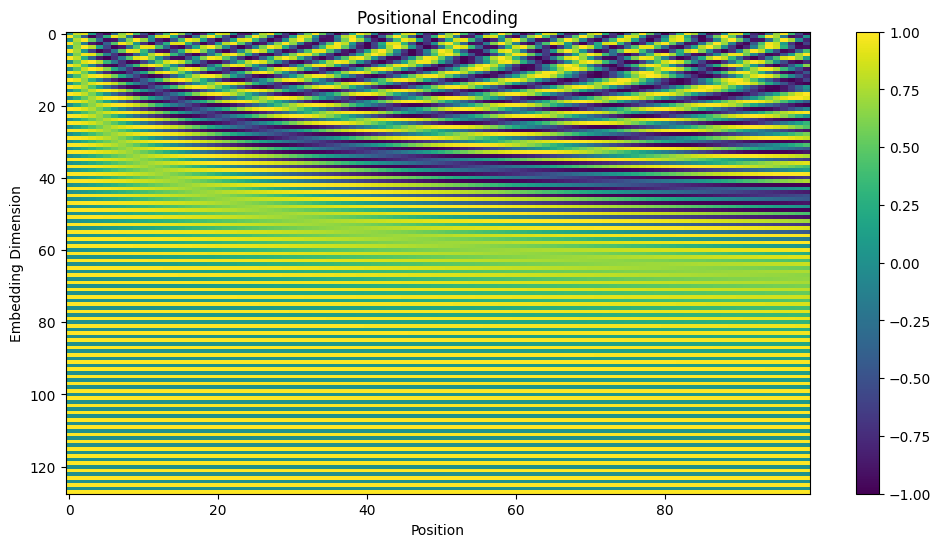

In [35]:
visualize_positional_encoding()

In [42]:
train_losses, val_accuracies = train_model(model, train_loader, test_loader, num_epochs=3)

Epoch 1: 100%|██████████| 125/125 [00:01<00:00, 82.22it/s]


Epoch 1: Loss = 0.0230, Val Accuracy = 1.0000


Epoch 2: 100%|██████████| 125/125 [00:01<00:00, 88.88it/s]


Epoch 2: Loss = 0.0001, Val Accuracy = 1.0000


Epoch 3: 100%|██████████| 125/125 [00:01<00:00, 84.28it/s]


Epoch 3: Loss = 0.0001, Val Accuracy = 1.0000


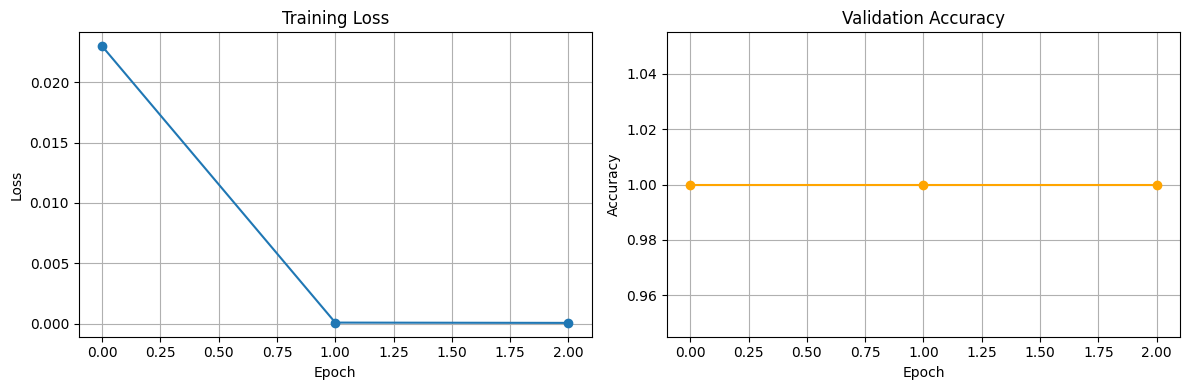

In [43]:
plot_training_metrics(train_losses, val_accuracies)

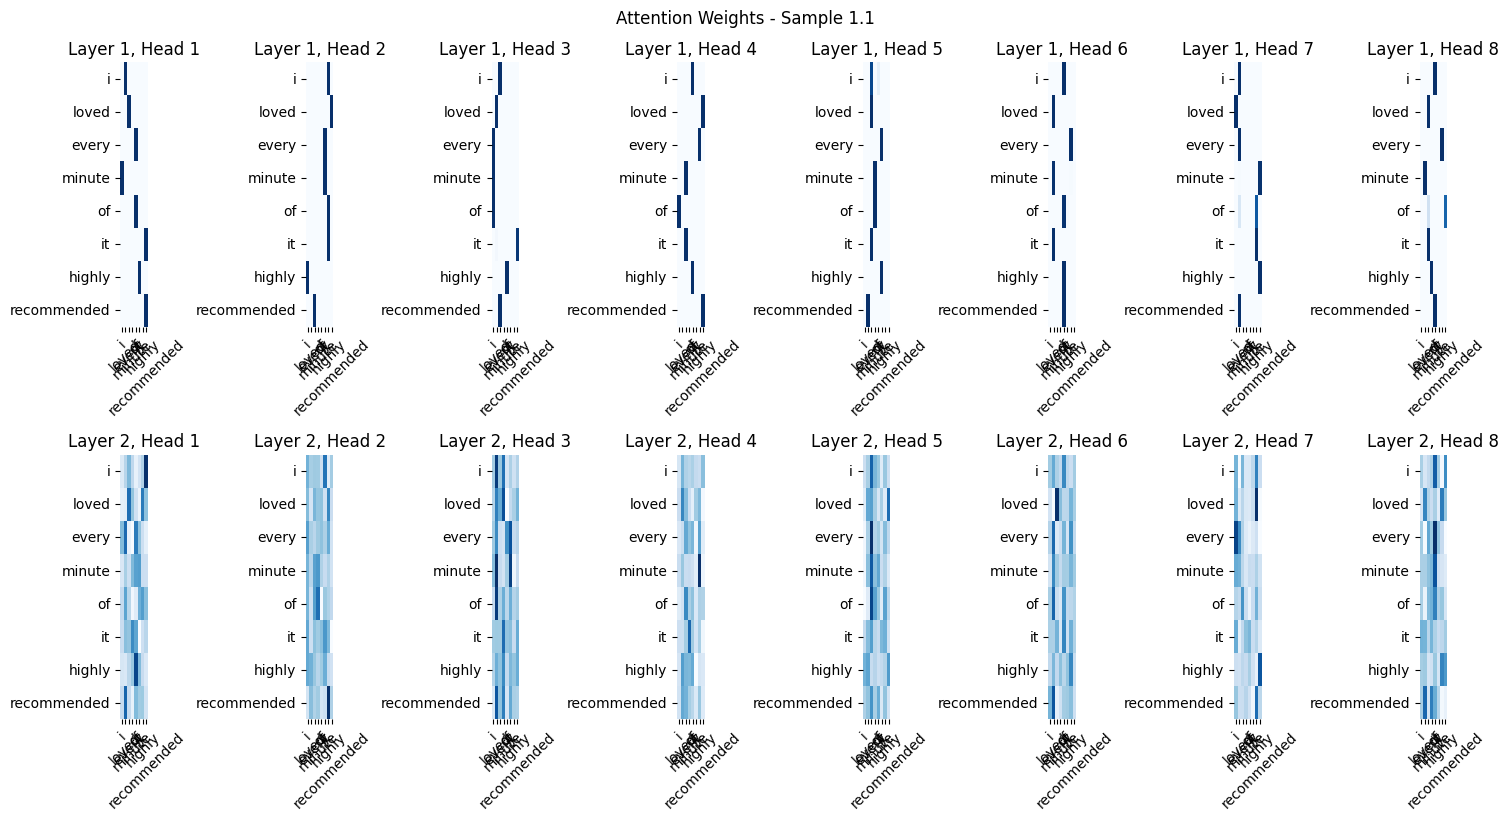

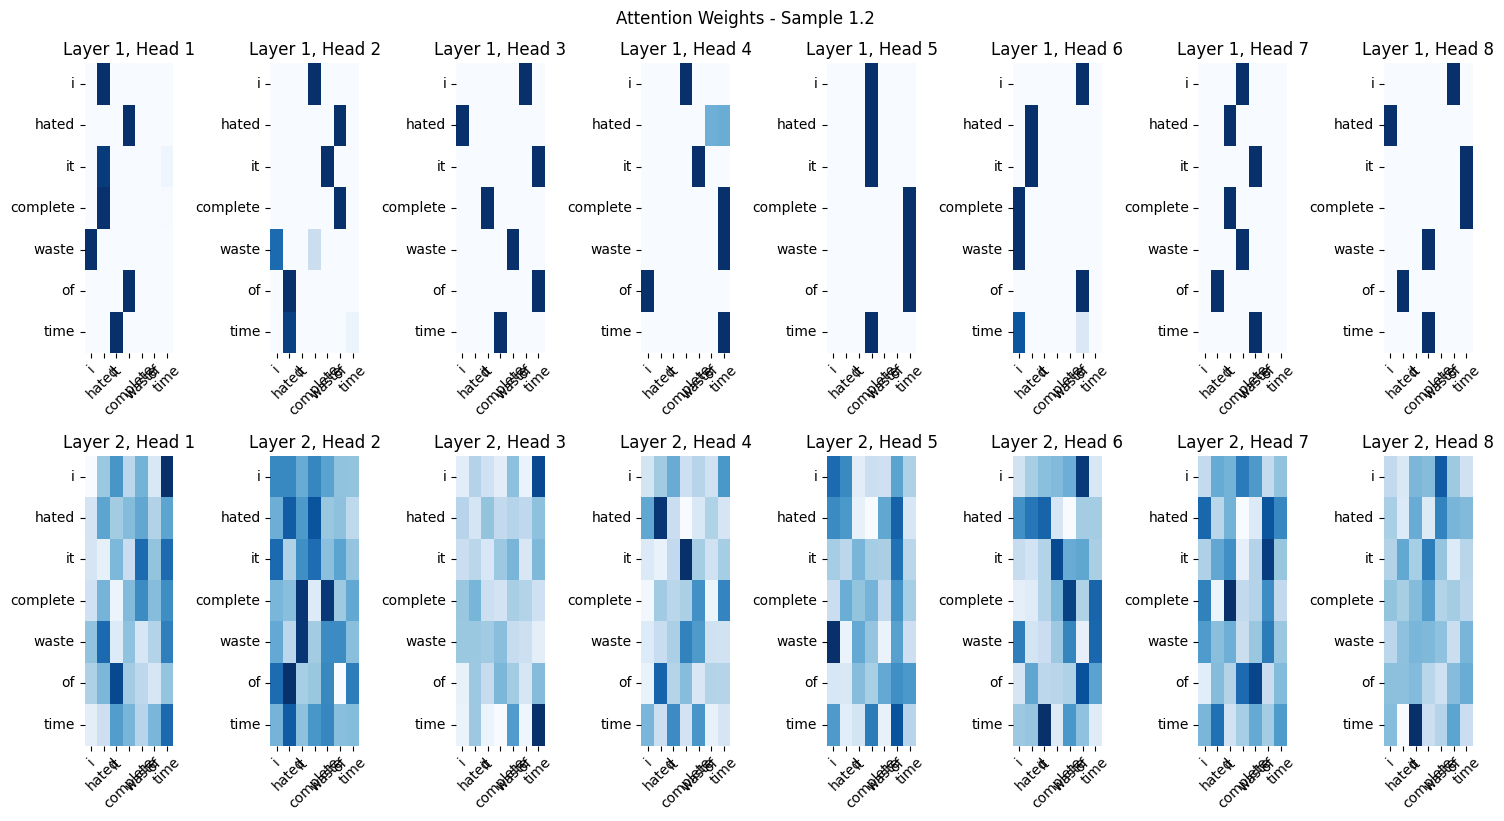

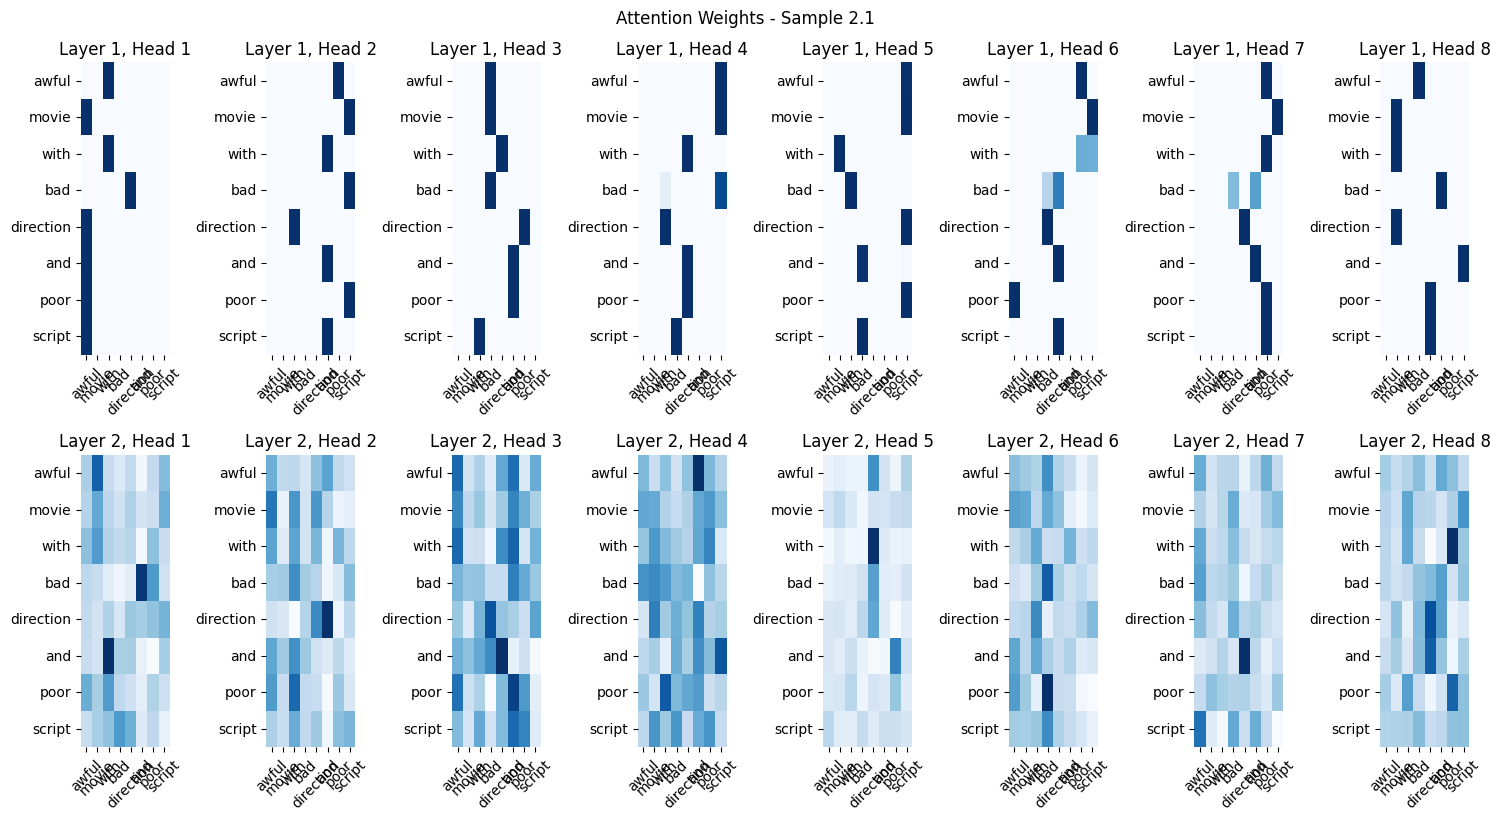

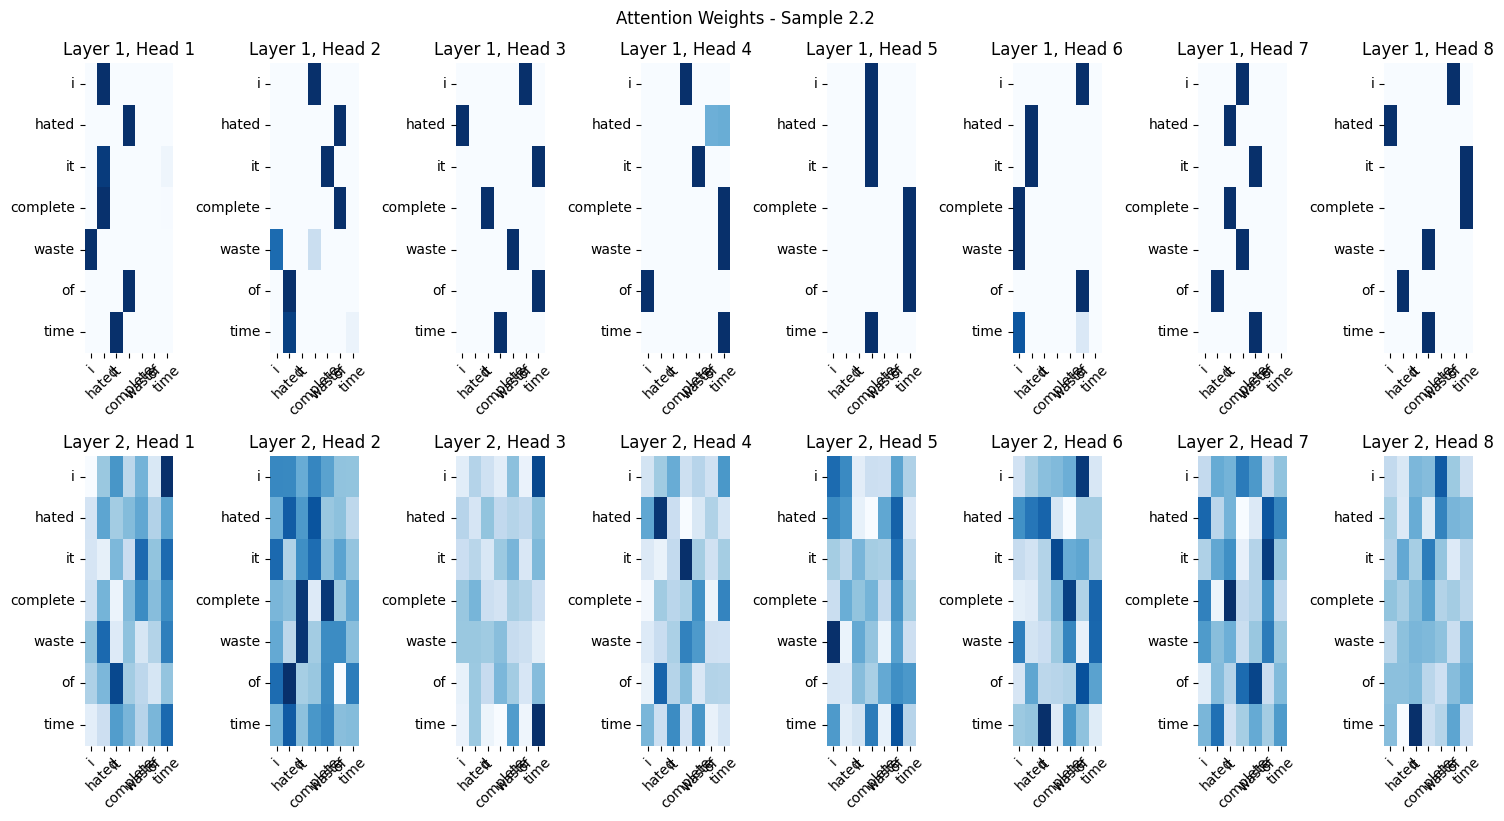

In [44]:
visualize_attention(model, test_loader, vocab_to_idx, idx_to_vocab, device, num_samples=2)

In [45]:
model.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        logits, _ = model(input_ids, attention_mask)
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = correct / total
print(f'Final Test Accuracy: {final_accuracy:.4f}')

Final Test Accuracy: 1.0000


In [46]:
print(classification_report(all_labels, all_predictions, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       500
    Positive       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

